#  Apps Dataset
Google Play Store dataset을 가져왔습니다.   
Rating 컬럼을 target으로 설정하고 예측하는 앙상블을 진행해봅시다  

## 앙상블 조건
1. 이상치 처리
2. 범주형 변수 처리 : 비슷한 것 끼리 묶기 , 더미변수화 등  
3. 베이스 모델 하이퍼파라미터 튜닝  
4. stacking : 최소 두 가지 방법 시도   
5. 앙상블에 대한 설명 주석을 마크다운으로 꼼꼼히!  

|  <center>변수명</center> |  <center>설명</center> |  <center>비고</center> |
|:--------|:--------|:--------|
| App | 어플명 | |  
| Rating | 평점 | target |
| Reviews | 리뷰갯수 | |
| Size | 어플 크기 | |
| Installs | 다운로드 횟수 | |
| Price | 가격 | |
| Content Rating | 관람가 | |
| Genres | 세부장르 | |
| Last Updated | 마지막 업데이트 | |

In [4]:
# ready
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization

from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

In [51]:
# Load Data
train = pd.read_csv('ggstore_train.csv',encoding = 'unicode_escape')
test = pd.read_csv('ggstore_test.csv',encoding = 'unicode_escape')

In [5]:
origin_test = pd.read_csv('ggstore_test.csv',encoding = 'unicode_escape')

In [247]:
origin_test.head(2)

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Dr.Android Repair Master 2017,PRODUCTIVITY,1205,4.3,100000.0,0,0.0,Everyone,Productivity,2018-06-10,5617
1,DR CONTROL,FAMILY,267,1.5,10000.0,0,0.0,Everyone,Entertainment,2017-03-08,5618


## 1. EDA & Data Processing


* 데이터 확인 및 결측치 확인

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
 11  Id              5616 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1404 non-null   object 
 1   Category        1404 non-null   object 
 2   Reviews         1404 non-null   int64  
 3   Size            1404 non-null   float64
 4   Installs        1404 non-null   float64
 5   Type            1404 non-null   int64  
 6   Price           1404 non-null   float64
 7   Content Rating  1404 non-null   object 
 8   Genres          1404 non-null   object 
 9   Last Updated    1404 non-null   object 
 10  Id              1404 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 120.8+ KB


In [5]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08,3
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20,4


#### 연속형 변수

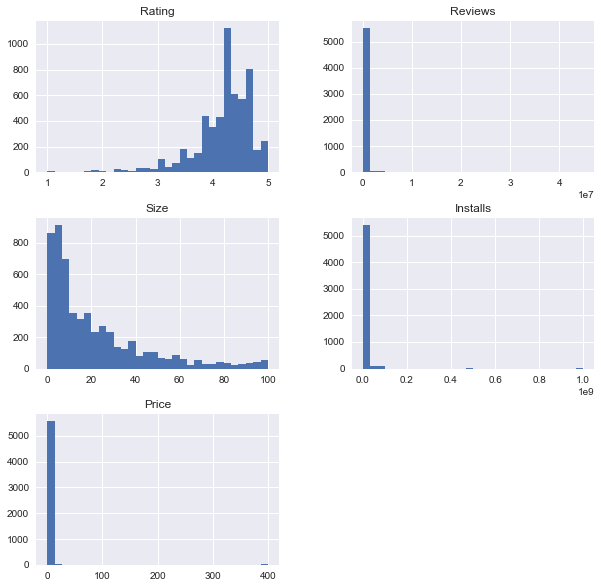

In [6]:
# 연속형 변수 분포 확인
continuous = train[['Rating','Reviews','Size','Installs','Price']]
continuous.hist(bins=30,figsize=(10,10))
plt.show()

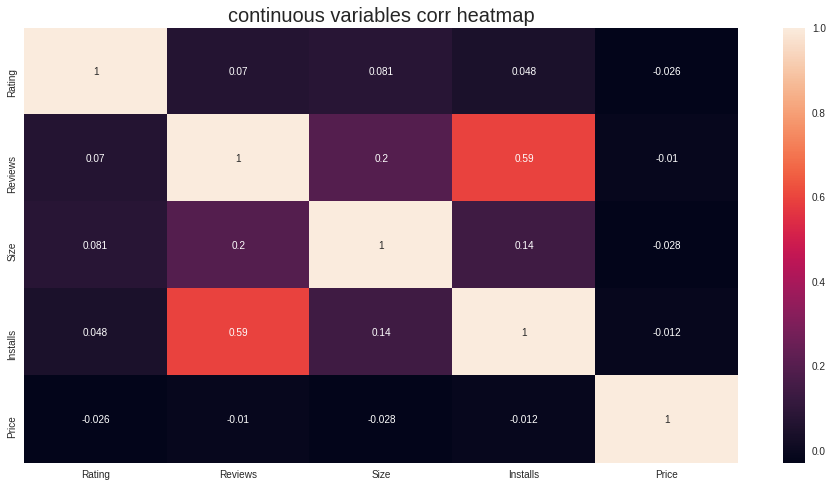

In [ ]:
# 연속형 변수 heatmap 상관관계 시각화
plt.figure(figsize=(16,8))
sns.heatmap(continuous.corr(), annot=True)
plt.title('continuous variables corr heatmap', fontsize=20)

plt.show()

installs와 Reviews의 상관성이 가장 크다.

### 연속형 변수 이상치 확인
Type 은 유무료를 나타내는 범주형

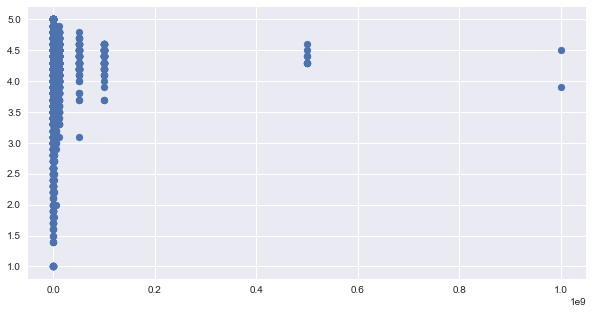

In [7]:
# Installs
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Installs'], y = continuous['Rating'])

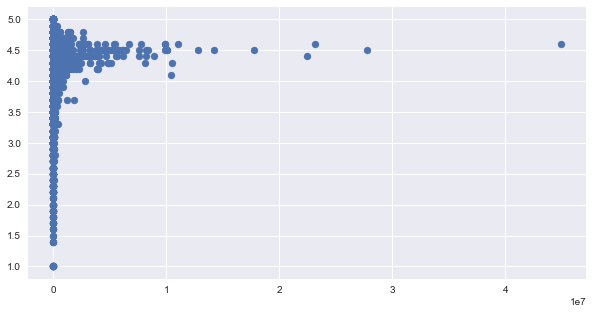

In [8]:
# Reviews
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Reviews'], y = continuous['Rating'])

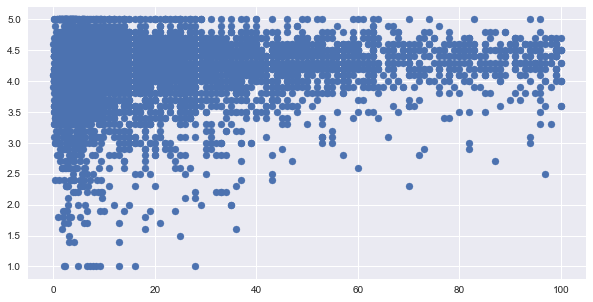

In [9]:
# Size
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Size'], y = continuous['Rating'])

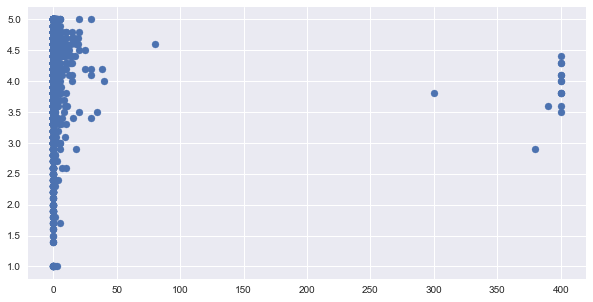

In [10]:
# Price
plt.figure(figsize=(10,5))
plt.scatter(x = continuous['Price'], y = continuous['Rating'])

#### IQR 기준으로 완전 이상한거 몇개만 제거 해 봅시다
저는 Installs,Reviews 와 Price에서만 제거해보겠습니당

* IQR 기준으로

In [11]:
def remove_outlier(df,col):
  data = df[col]
  q25 = np.percentile(data.values,25)
  q75 = np.percentile(data.values,75)

  IQR = q75 - q25
  IQR = IQR * 1.5
  low = q25-IQR ; high = q75+IQR
  outlier_index = data[(data<low)|(data>high)].index
  #print(len(outlier_index))
  #df.drop(outlier_index, axis=0, inplace=True)
  #print(df.shape)
  #return df
  return len(outlier_index)

In [12]:
print(remove_outlier(continuous,'Installs'))
print(remove_outlier(continuous,'Reviews'))
print(remove_outlier(continuous,'Price'))

1162
924
441


IQR 기준이면 너무 많은 이상치가 발견되서 데이터 손실이 너무 컸습니다!  
scatter plot 에 당장 눈에 보이는 정말 몇개만 제거합시다  


* 직관적으로

In [13]:
out_installs = continuous[continuous['Installs'] > 200000000]
out_price = continuous[continuous['Price'] > 250]
out_reviews = continuous[continuous['Reviews'] > 15000000]
print(len(out_installs))
print(len(out_price))
print(len(out_reviews))

10
15
5


In [52]:
continuous = continuous.query('Installs < 200000000 and Price < 250 and Reviews < 40000000')
continuous.shape

(5590, 5)

저는 이정도만 하겠습니다.
scaling과 feature engineering을 더 하실 분은 하셔도 됩니다!  

### 범주형 변수 확인  
Category, Content Rating, Genres 확인

In [15]:
category_count = train['Category'].value_counts()
category_count

FAMILY                 1102
GAME                    657
TOOLS                   463
MEDICAL                 253
PERSONALIZATION         227
LIFESTYLE               220
FINANCE                 201
PHOTOGRAPHY             175
PRODUCTIVITY            173
HEALTH_AND_FITNESS      172
BUSINESS                166
COMMUNICATION           153
SPORTS                  143
SHOPPING                139
SOCIAL                  122
DATING                  121
NEWS_AND_MAGAZINES      114
BOOKS_AND_REFERENCE     109
TRAVEL_AND_LOCAL        108
VIDEO_PLAYERS            90
EDUCATION                88
MAPS_AND_NAVIGATION      76
FOOD_AND_DRINK           69
ENTERTAINMENT            64
LIBRARIES_AND_DEMO       57
ART_AND_DESIGN           57
AUTO_AND_VEHICLES        55
HOUSE_AND_HOME           48
COMICS                   46
PARENTING                43
WEATHER                  37
BEAUTY                   34
EVENTS                   34
Name: Category, dtype: int64

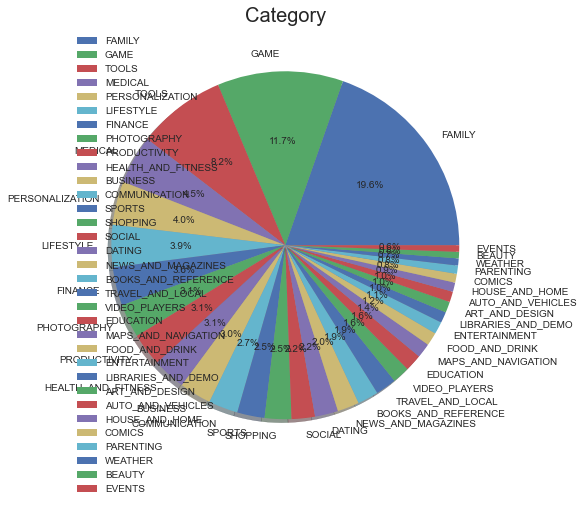

In [16]:
# Category 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(category_count,labels=category_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Category',size = 20)
plt.legend()
plt.show()

In [35]:
len(category_count)

33

In [19]:
genres_count = train['Genres'].value_counts()
genres_count

Tools                                    463
Entertainment                            337
Education                                309
Medical                                  253
Personalization                          227
Lifestyle                                219
Action                                   214
Finance                                  201
Photography                              175
Productivity                             173
Health & Fitness                         172
Business                                 166
Communication                            153
Sports                                   149
Shopping                                 139
Arcade                                   129
Social                                   122
Dating                                   121
News & Magazines                         114
Simulation                               110
Books & Reference                        109
Travel & Local                           107
Video Play

In [36]:
len(genres_count)

106

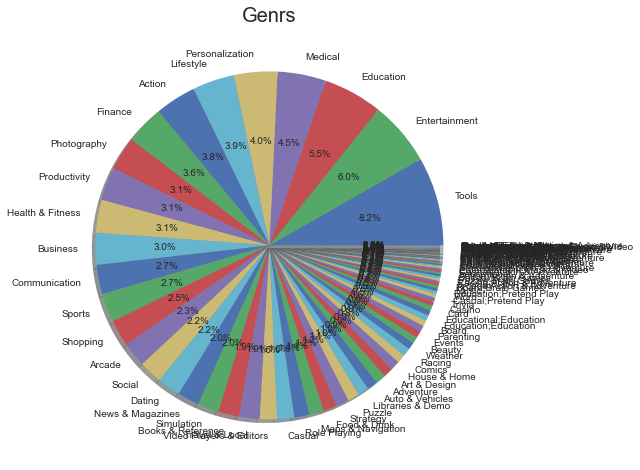

In [20]:
# Genrs 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(genres_count,labels=genres_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Genrs',size = 20)
plt.show()

- genre와 category를 합친다.
- content rating의 겹치는 나이대를 합친다.

우선 genre와 category의 겹치는 항목이 얼마나 존재하는지 알아보겠습니다.

In [53]:
genre_uni = train['Genres'].unique()
genre_uni = [i.lower() for i in genre_uni]
category_uni = train['Category'].unique()
category_uni = [i.lower() for i in category_uni]

In [54]:
inter = list(set(genre_uni).intersection(set(category_uni)))
inter

['tools',
 'weather',
 'productivity',
 'dating',
 'medical',
 'sports',
 'photography',
 'beauty',
 'entertainment',
 'lifestyle',
 'personalization',
 'parenting',
 'social',
 'education',
 'comics',
 'communication',
 'finance',
 'shopping',
 'events',
 'business']

In [55]:
len(inter)

20

genre와 category는 중복된 정보를 가지고 있습니다.

In [56]:
origin_train = train.copy()

- ### 범주형 변수 처리 - Genres와 Category의 병합
장르는 상위 장르와 하위 장르로 이루어져 있다. 구분은 ; 로 되어있기 때문에 이를 기준으로 나누어준다.

In [57]:
train['Genres']  = train['Genres'].str.strip()

train[['up_Genres', 'low_Genres']] = train['Genres'].str.split(';', n=1, expand=True)

In [61]:
train.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id,up_Genres,low_Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0,Art & Design,None
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1,Art & Design,Pretend Play
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2,Art & Design,None


In [64]:
train['low_Genres'].fillna('', inplace=True)
train[train['low_Genres'].str.contains(';')] 

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id,up_Genres,low_Genres


장르 구분 단계가 3단계이상인 케이스는 없다.

In [73]:
#비교를 위해 모두 소문자로 바꾼다.
train['Category'] = train['Category'].str.lower()
train['Genres'] = train['Genres'].str.lower()
train['up_Genres'] = train['up_Genres'].str.lower()
train['low_Genres'] = train['low_Genres'].str.lower()

In [84]:
train[train['Category']!=train['up_Genres']].head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id,up_Genres,low_Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19.0,10000.0,0,0.0,Everyone,art & design,2018-01-07,0,art & design,
1,Coloring book moana,art_and_design,3.9,967,14.0,500000.0,0,0.0,Everyone,art & design;pretend play,2018-01-15,1,art & design,pretend play
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",art_and_design,4.7,87510,8.7,5000000.0,0,0.0,Everyone,art & design,2018-08-01,2,art & design,
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25.0,50000000.0,0,0.0,Teen,art & design,2018-06-08,3,art & design,
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8,100000.0,0,0.0,Everyone,art & design;creativity,2018-06-20,4,art & design,creativity
5,Paper flowers instructions,art_and_design,4.4,167,5.6,50000.0,0,0.0,Everyone,art & design,2017-03-26,5,art & design,
6,Smoke Effect Photo Maker - Smoke Editor,art_and_design,3.8,178,19.0,50000.0,0,0.0,Everyone,art & design,2018-04-26,6,art & design,
7,Infinite Painter,art_and_design,4.1,36815,29.0,1000000.0,0,0.0,Everyone,art & design,2018-06-14,7,art & design,
8,Garden Coloring Book,art_and_design,4.4,13791,33.0,1000000.0,0,0.0,Everyone,art & design,2017-09-20,8,art & design,
9,Kids Paint Free - Drawing Fun,art_and_design,4.7,121,3.1,10000.0,0,0.0,Everyone,art & design;creativity,2018-07-03,9,art & design,creativity


In [85]:
a = train['up_Genres'].unique().tolist()
b = train['Category'].unique().tolist()
print(len(a), len(b))

48 33


In [86]:
print(a)
print(b)

['art & design', 'auto & vehicles', 'beauty', 'books & reference', 'business', 'comics', 'communication', 'dating', 'education', 'entertainment', 'events', 'finance', 'food & drink', 'health & fitness', 'house & home', 'libraries & demo', 'lifestyle', 'adventure', 'arcade', 'casual', 'card', 'strategy', 'action', 'puzzle', 'sports', 'word', 'racing', 'simulation', 'board', 'trivia', 'role playing', 'educational', 'music', 'music & audio', 'video players & editors', 'medical', 'social', 'shopping', 'photography', 'travel & local', 'tools', 'personalization', 'productivity', 'parenting', 'weather', 'news & magazines', 'maps & navigation', 'casino']
['art_and_design', 'auto_and_vehicles', 'beauty', 'books_and_reference', 'business', 'comics', 'communication', 'dating', 'education', 'entertainment', 'events', 'finance', 'food_and_drink', 'health_and_fitness', 'house_and_home', 'libraries_and_demo', 'lifestyle', 'game', 'family', 'medical', 'social', 'shopping', 'photography', 'sports', 'tr

up_Genres와 Category의 분류는 거의 일치하나, up_Genres가 15개의 범주를 더 가지고 있다. 
up_Genres를 사용하도록 하겠다.

In [87]:
train_category = train.copy()

In [88]:
train = train.drop(['low_Genres','Genres','Category'],axis=1)

In [89]:
train.head(3)

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Id,up_Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000.0,0,0.0,Everyone,2018-01-07,0,art & design
1,Coloring book moana,3.9,967,14.0,500000.0,0,0.0,Everyone,2018-01-15,1,art & design
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",4.7,87510,8.7,5000000.0,0,0.0,Everyone,2018-08-01,2,art & design


In [90]:
con_rating_count = train['Content Rating'].value_counts()
con_rating_count

Everyone           4531
Teen                589
Mature 17+          281
Everyone 10+        212
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

- ### 범주형 변수 처리 - Content Rating 3단계로 재분류

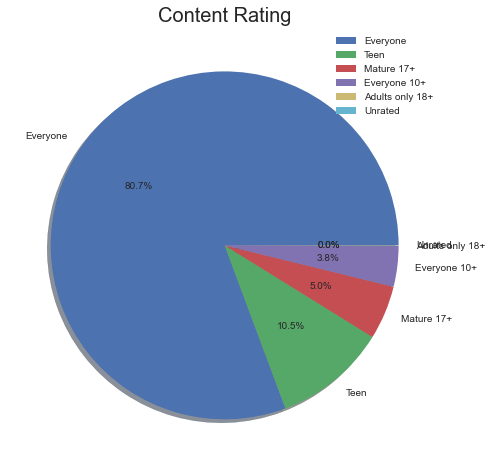

In [91]:
# Content Rating 시각화
fig = plt.figure(figsize=(16,8)) 
plt.pie(con_rating_count,labels=con_rating_count.index,autopct='%1.1f%%', shadow=True)
plt.title('Content Rating',size = 20)
plt.legend()
plt.show()

Everyone: 6세 이상

Everyone 10+ : 10세 이상

Teen : 13세 이상

Mature 17+ : 17세 이상

Adults only 18+ : 18세 이상

Unrated : 평가되지 않음 

이므로, 3단계로 재구성 Everyone/ Everyone 10+ Teen/ Mature 17+, Adults only 18+ (Unrated 데이터 1개 삭제)

In [94]:
# train[train['Content Rating']=='Everyone 10+']
train.drop(train.loc[train['Content Rating']=='Unrated'].index, inplace=True) # 1개 데이터 삭제

def custom(COL) :
    if COL=='Everyone':
        return 'A'
    elif COL=='Everyone 10+' or COL=='Teen':
        return 'B'
    else :
        return 'C'
    
train["New_content_rating"] = train.apply(lambda x : custom(x["Content Rating"]) , axis = 1 )

In [100]:
train = train.drop(['Content Rating','Id'], axis=1) # Id는 필요하지 않다.

In [101]:
train.head(3)

,App,Rating,Reviews,Size,Installs,Type,Price,Last Updated,up_Genres,New_content_rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000.0,0,0.0,2018-01-07,art & design,A
1,Coloring book moana,3.9,967,14.0,500000.0,0,0.0,2018-01-15,art & design,A
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",4.7,87510,8.7,5000000.0,0,0.0,2018-08-01,art & design,A


In [102]:
train.to_csv('app_data_complete.csv')

In [140]:
train = pd.read_csv('app_data_complete.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)

### 범주형 변수 - 더미변수화

In [141]:
cat_col = ['up_Genres', 'New_content_rating']

train = pd.get_dummies(train, columns=cat_col)

In [142]:
train.head(3)

,App,Rating,Reviews,Size,Installs,Type,Price,Last Updated,up_Genres_action,up_Genres_adventure,up_Genres_arcade,up_Genres_art & design,up_Genres_auto & vehicles,up_Genres_beauty,up_Genres_board,up_Genres_books & reference,up_Genres_business,up_Genres_card,up_Genres_casino,up_Genres_casual,up_Genres_comics,up_Genres_communication,up_Genres_dating,up_Genres_education,up_Genres_educational,up_Genres_entertainment,up_Genres_events,up_Genres_finance,up_Genres_food & drink,up_Genres_health & fitness,up_Genres_house & home,up_Genres_libraries & demo,up_Genres_lifestyle,up_Genres_maps & navigation,up_Genres_medical,up_Genres_music,up_Genres_music & audio,up_Genres_news & magazines,up_Genres_parenting,up_Genres_personalization,up_Genres_photography,up_Genres_productivity,up_Genres_puzzle,up_Genres_racing,up_Genres_role playing,up_Genres_shopping,up_Genres_simulation,up_Genres_social,up_Genres_sports,up_Genres_strategy,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,up_Genres_video players & editors,up_Genres_weather,up_Genres_word,New_content_rating_A,New_content_rating_B,New_content_rating_C
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000.0,0,0.0,2018-01-07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Coloring book moana,3.9,967,14.0,500000.0,0,0.0,2018-01-15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,"U Launcher Lite â FREE Live Cool Themes, Hid...",4.7,87510,8.7,5000000.0,0,0.0,2018-08-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [143]:
train = train.query('Installs < 200000000 and Price < 250 and Reviews < 40000000')

In [144]:
train.shape

(5589, 59)

In [145]:
train.drop('App',axis=1,inplace=True)

#### last_update변수 처리를 깜박했네요. last update변수의 year정보만 추출한 다음 더미변수화하도록 하겠습니다!!

In [152]:
train['Last Updated'] = pd.to_datetime(train['Last Updated'], format='%Y-%m-%d %H:%M:%S', errors='raise')

train['update_year'] = train['Last Updated'].dt.year

In [155]:
train.head(3)

,Rating,Reviews,Size,Installs,Type,Price,Last Updated,up_Genres_action,up_Genres_adventure,up_Genres_arcade,up_Genres_art & design,up_Genres_auto & vehicles,up_Genres_beauty,up_Genres_board,up_Genres_books & reference,up_Genres_business,up_Genres_card,up_Genres_casino,up_Genres_casual,up_Genres_comics,up_Genres_communication,up_Genres_dating,up_Genres_education,up_Genres_educational,up_Genres_entertainment,up_Genres_events,up_Genres_finance,up_Genres_food & drink,up_Genres_health & fitness,up_Genres_house & home,up_Genres_libraries & demo,up_Genres_lifestyle,up_Genres_maps & navigation,up_Genres_medical,up_Genres_music,up_Genres_music & audio,up_Genres_news & magazines,up_Genres_parenting,up_Genres_personalization,up_Genres_photography,up_Genres_productivity,up_Genres_puzzle,up_Genres_racing,up_Genres_role playing,up_Genres_shopping,up_Genres_simulation,up_Genres_social,up_Genres_sports,up_Genres_strategy,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,up_Genres_video players & editors,up_Genres_weather,up_Genres_word,New_content_rating_A,New_content_rating_B,New_content_rating_C,update_year
0,4.1,159,19.0,10000.0,0,0.0,2018-01-07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2018
1,3.9,967,14.0,500000.0,0,0.0,2018-01-15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2018
2,4.7,87510,8.7,5000000.0,0,0.0,2018-08-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2018


In [ ]:
train.drop('Last Updated', axis=1, inplace=True)

In [158]:
train = pd.get_dummies(train, columns=['update_year'])

In [160]:
train.head(3)

,Rating,Reviews,Size,Installs,Type,Price,up_Genres_action,up_Genres_adventure,up_Genres_arcade,up_Genres_art & design,up_Genres_auto & vehicles,up_Genres_beauty,up_Genres_board,up_Genres_books & reference,up_Genres_business,up_Genres_card,up_Genres_casino,up_Genres_casual,up_Genres_comics,up_Genres_communication,up_Genres_dating,up_Genres_education,up_Genres_educational,up_Genres_entertainment,up_Genres_events,up_Genres_finance,up_Genres_food & drink,up_Genres_health & fitness,up_Genres_house & home,up_Genres_libraries & demo,up_Genres_lifestyle,up_Genres_maps & navigation,up_Genres_medical,up_Genres_music,up_Genres_music & audio,up_Genres_news & magazines,up_Genres_parenting,up_Genres_personalization,up_Genres_photography,up_Genres_productivity,up_Genres_puzzle,up_Genres_racing,up_Genres_role playing,up_Genres_shopping,up_Genres_simulation,up_Genres_social,up_Genres_sports,up_Genres_strategy,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,up_Genres_video players & editors,up_Genres_weather,up_Genres_word,New_content_rating_A,New_content_rating_B,New_content_rating_C,update_year_2010,update_year_2011,update_year_2012,update_year_2013,update_year_2014,update_year_2015,update_year_2016,update_year_2017,update_year_2018
0,4.1,159,19.0,10000.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,3.9,967,14.0,500000.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,4.7,87510,8.7,5000000.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [176]:
train = pd.get_dummies(train, columns=['Type'])

In [177]:
train.to_csv('all_completed.csv', index=False)

In [179]:
train.head(3)

,Rating,Reviews,Size,Installs,Price,up_Genres_action,up_Genres_adventure,up_Genres_arcade,up_Genres_art & design,up_Genres_auto & vehicles,up_Genres_beauty,up_Genres_board,up_Genres_books & reference,up_Genres_business,up_Genres_card,up_Genres_casino,up_Genres_casual,up_Genres_comics,up_Genres_communication,up_Genres_dating,up_Genres_education,up_Genres_educational,up_Genres_entertainment,up_Genres_events,up_Genres_finance,up_Genres_food & drink,up_Genres_health & fitness,up_Genres_house & home,up_Genres_libraries & demo,up_Genres_lifestyle,up_Genres_maps & navigation,up_Genres_medical,up_Genres_music,up_Genres_music & audio,up_Genres_news & magazines,up_Genres_parenting,up_Genres_personalization,up_Genres_photography,up_Genres_productivity,up_Genres_puzzle,up_Genres_racing,up_Genres_role playing,up_Genres_shopping,up_Genres_simulation,up_Genres_social,up_Genres_sports,up_Genres_strategy,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,up_Genres_video players & editors,up_Genres_weather,up_Genres_word,New_content_rating_A,New_content_rating_B,New_content_rating_C,update_year_2010,update_year_2011,update_year_2012,update_year_2013,update_year_2014,update_year_2015,update_year_2016,update_year_2017,update_year_2018,Type_0,Type_1
0,4.1,159,19.0,10000.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
1,3.9,967,14.0,500000.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
2,4.7,87510,8.7,5000000.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


train 데이터는 전처리가 완료되었으니 저장해두겠습니다

#### test 데이터도 1. genre의 상위 장르 추출, 2. content rating 3단계로 재분류 3. Last Updated의 year추출 후 더미변수화를 진행하겠습니다.

In [206]:
test.drop(['Id','App','Category'], axis=1, inplace=True)

In [207]:
test.head(2)

,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,1205,4.3,100000.0,0,0.0,Everyone,Productivity,2018-06-10
1,267,1.5,10000.0,0,0.0,Everyone,Entertainment,2017-03-08


In [208]:
#  1. genre의 상위 장르 추출
test['Genres']  = test['Genres'].str.strip()

test['Genres']  = test['Genres'].str.lower()

test[['up_Genres', 'low_Genres']] = test['Genres'].str.split(';', n=1, expand=True)

In [209]:
test.drop(['low_Genres', 'Genres'], axis=1, inplace=True)

In [211]:
test.head(2)

,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,up_Genres
0,1205,4.3,100000.0,0,0.0,Everyone,2018-06-10,productivity
1,267,1.5,10000.0,0,0.0,Everyone,2017-03-08,entertainment


In [210]:
# 2. content rating 3단계로 재분류
len(test[test['Content Rating']=='Unrated']) # test data에 unrated가 없네요 다행입니다ㅋㅋ

0

In [212]:
def custom(COL) :
    if COL=='Everyone':
        return 'A'
    elif COL=='Everyone 10+' or COL=='Teen':
        return 'B'
    else :
        return 'C'
    
test["New_content_rating"] = test.apply(lambda x : custom(x["Content Rating"]) , axis = 1 )

In [213]:
test.drop('Content Rating', axis=1, inplace=True)

In [214]:
test.head(2)

,Reviews,Size,Installs,Type,Price,Last Updated,up_Genres,New_content_rating
0,1205,4.3,100000.0,0,0.0,2018-06-10,productivity,A
1,267,1.5,10000.0,0,0.0,2017-03-08,entertainment,A


In [215]:
# 3. Last Updated의 year추출
test['Last Updated'] = pd.to_datetime(test['Last Updated'], format='%Y-%m-%d %H:%M:%S', errors='raise')

test['update_year'] = test['Last Updated'].dt.year

test.drop('Last Updated', axis=1, inplace=True)

In [216]:
test.head(2)

,Reviews,Size,Installs,Type,Price,up_Genres,New_content_rating,update_year
0,1205,4.3,100000.0,0,0.0,productivity,A,2018
1,267,1.5,10000.0,0,0.0,entertainment,A,2017


In [217]:
cat_col = ['Type', 'up_Genres','New_content_rating','update_year']
test = pd.get_dummies(test, columns=cat_col)

In [218]:
test.head(2)

,Reviews,Size,Installs,Price,Type_0,Type_1,up_Genres_action,up_Genres_adventure,up_Genres_arcade,up_Genres_art & design,up_Genres_auto & vehicles,up_Genres_beauty,up_Genres_board,up_Genres_books & reference,up_Genres_business,up_Genres_card,up_Genres_casino,up_Genres_casual,up_Genres_comics,up_Genres_communication,up_Genres_dating,up_Genres_education,up_Genres_educational,up_Genres_entertainment,up_Genres_events,up_Genres_finance,up_Genres_food & drink,up_Genres_health & fitness,up_Genres_house & home,up_Genres_libraries & demo,up_Genres_lifestyle,up_Genres_maps & navigation,up_Genres_medical,up_Genres_music,up_Genres_news & magazines,up_Genres_parenting,up_Genres_personalization,up_Genres_photography,up_Genres_productivity,up_Genres_puzzle,up_Genres_racing,up_Genres_role playing,up_Genres_shopping,up_Genres_simulation,up_Genres_social,up_Genres_sports,up_Genres_strategy,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,up_Genres_video players & editors,up_Genres_weather,up_Genres_word,New_content_rating_A,New_content_rating_B,New_content_rating_C,update_year_2011,update_year_2012,update_year_2013,update_year_2014,update_year_2015,update_year_2016,update_year_2017,update_year_2018
0,1205,4.3,100000.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,267,1.5,10000.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [222]:
print(len(train.columns),len(test.columns))
set(train.columns) - set(test.columns) # train에만 있는 항목들

67 64


{'Rating', 'up_Genres_music & audio', 'update_year_2010'}

In [223]:
test.to_csv('all_completed_test.csv', index=False)

In [6]:
train = pd.read_csv('all_completed.csv')
test = pd.read_csv('all_completed_test.csv')

## 2. Regression Modeling  

In [29]:
train = pd.read_csv('/content/drive/MyDrive/tobigs/all_completed.csv') 
test = pd.read_csv('/content/drive/MyDrive/tobigs/completed_test.csv') 

In [30]:
# sklearn 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR,LinearSVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost
import lightgbm

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression

In [31]:
# target 분리, data split
y = train['Rating']
X = train.drop('Rating',axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=318)

In [32]:
# Update test data
origin_test = pd.read_csv('/content/drive/MyDrive/tobigs/ggstore_test.csv')
test_ID = origin_test['Id']

* validation function

In [33]:
n_folds = 5
train = X
def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
  rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

In [34]:
def new_rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=5))
    return (rmse)

In [35]:
def rmse(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

- 참고

scoring='neg_mean_squared_error'를 쓰는 이유는 scoring 매개변수에 클수록 좋은 함수를 기대하기 때문에 -mse를 쓰고 나서 나중에 다시 -를 곱해줍니다.

### Base models  


In [36]:
#evaluation - baselines
num_folds = 5
seed = 7
scoring = 'neg_mean_squared_error'
models = []
models.append(('lr', make_pipeline(RobustScaler(), SelectKBest(f_regression, k=20),LinearRegression())))
models.append(('dt', make_pipeline(SelectKBest(f_regression, k=20), DecisionTreeRegressor())))
models.append(('knn', make_pipeline(RobustScaler(),SelectKBest(f_regression, k=20),KNeighborsRegressor(n_neighbors = 3))))
models.append(('svm', make_pipeline(RobustScaler(),SelectKBest(f_regression, k=20),SVR())))
models.append(('rf', make_pipeline(SelectKBest(f_regression, k=20),SVR())))
models.append(('gbm', make_pipeline(SelectKBest(f_regression, k=20),RandomForestRegressor())))
models.append(('xgb', make_pipeline(SelectKBest(f_regression, k=20),GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10,
                                              loss = 'huber', random_state=1004))))
models.append(('lgb', make_pipeline(SelectKBest(f_regression, k=20),lightgbm.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20))))

results = []
names = []
for name, model in models:
    # kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=5))
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

lr 0.523192 0.025393 
dt 0.698918 0.051530 
knn 0.574472 0.022619 
svm 0.527130 0.026181 
rf 0.545707 0.026694 
gbm 0.523073 0.024395 
xgb 0.510467 0.021647 
lgb 0.505661 0.023874 


가장 적은 rmse를 보이는 것은 lgb모델입니다. 이를 튜닝해보겠습니다.

### 베이스 모델 튜닝
* Grid search, optuna , random Search 등을 이용해서 파라미터를 튜닝해주세요~!

In [ ]:
num_folds = 5
seed = 7
scoring = 'neg_mean_squared_error'
param_grid = {
    "lgbm__n_estimators" : [10, 20, 30, 50, 100, 200, 300],
    "lgbm__learning_rate" : [i for i in np.linspace(0.1,1, 10)],
    "lgbm__num_iteration" : range(100, 1100, 200)
    }
step1 = ('select', SelectKBest(f_regression, k=20))    
step2 = ('lgbm', lightgbm.LGBMRegressor(objective='regression'))              
model = Pipeline([step1, step2])
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, verbose=3)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [24]:
test.drop('Unnamed: 0',axis=1,inplace=True)

In [26]:
print(train.shape, test.shape)

(5589, 66) (1404, 66)


In [18]:
# 모델 저장
import pickle
# Best XGB model that was found based on the metric score you specify
best_pars = grid.best_params_
best_model = grid.best_estimator_

# Save model
pickle.dump(grid.best_estimator_, open("xgb_log_reg_selection.pickle", "wb"))
model = grid.best_estimator_
lgb_pred = model.predict(new_X_test)

# 최종 test 예측
lgb_pred = model.predict(test.values)
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = lgb_pred
sub.to_csv('submission_2.csv',index=False)

In [ ]:
sub.head()

,Id,Rating
0,5617,4.366667
1,5618,4.166667
2,5619,4.133333
3,5620,4.566667
4,5621,4.400000


submission2의 정확도가 베이스라인보다도 좋지 않습니다. 범주형 변수의 범주가 많아서 변수가 너무 많아진 것이 이유인 것 같습니다. 

train할때 selectkbest를 사용할 수 있었지만 이는 타겟과 다른 피쳐들의 상관관계를 파악해서 feature selection을 하는 것이라 아예 모르는 테스트 데이터에 적용할 수 없습니다. 

따라서, selectkbest를 이용하여 처음부터 feature selection을 해준 후에 모델 학습을 해보겠습니다.

In [40]:
# target(Price)와 가장 correlated 된 features 를 k개 고르기.
## f_regresison, SelectKBest 불러오기.
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=20)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((3912, 20), (1677, 20))

In [41]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성(변수)들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['Reviews', 'Size', 'Installs', 'up_Genres_art & design',
       'up_Genres_books & reference', 'up_Genres_dating',
       'up_Genres_education', 'up_Genres_entertainment', 'up_Genres_events',
       'up_Genres_personalization', 'up_Genres_puzzle', 'up_Genres_tools',
       'up_Genres_travel & local', 'up_Genres_trivia', 'update_year_2015',
       'update_year_2016', 'update_year_2017', 'update_year_2018', 'Type_0',
       'Type_1'],
      dtype='object')
Unselected names:  Index(['Price', 'up_Genres_action', 'up_Genres_adventure', 'up_Genres_arcade',
       'up_Genres_auto & vehicles', 'up_Genres_beauty', 'up_Genres_board',
       'up_Genres_business', 'up_Genres_card', 'up_Genres_casino',
       'up_Genres_casual', 'up_Genres_comics', 'up_Genres_communication',
       'up_Genres_educational', 'up_Genres_finance', 'up_Genres_food & drink',
       'up_Genres_health & fitness', 'up_Genres_house & home',
       'up_Genres_libraries & demo', 'up_Genres_lifestyle',
 

In [43]:
# 선정된 feature 20개 변수에 담기.
features_20 = ['Reviews', 'Size', 'Installs', 'up_Genres_art & design',
       'up_Genres_books & reference', 'up_Genres_dating',
       'up_Genres_education', 'up_Genres_entertainment', 'up_Genres_events',
       'up_Genres_personalization', 'up_Genres_puzzle', 'up_Genres_tools',
       'up_Genres_travel & local', 'up_Genres_trivia', 'update_year_2015',
       'update_year_2016', 'update_year_2017', 'update_year_2018', 'Type_0',
       'Type_1']

new_X_train = X_train[features_20]
new_X_test = X_test[features_20]

new_X_train.head()

,Reviews,Size,Installs,up_Genres_art & design,up_Genres_books & reference,up_Genres_dating,up_Genres_education,up_Genres_entertainment,up_Genres_events,up_Genres_personalization,up_Genres_puzzle,up_Genres_tools,up_Genres_travel & local,up_Genres_trivia,update_year_2015,update_year_2016,update_year_2017,update_year_2018,Type_0,Type_1
4590,1995,92.0,500000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
5284,10786,21.0,1000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1091,4230886,60.0,100000000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4937,6,7.8,1000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
624,8662,38.0,100000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [ ]:
num_folds = 5
seed = 7
scoring = 'neg_mean_squared_error'
param_grid = {
    "lgbm__n_estimators" : [10, 20, 30, 50, 100, 200, 300],
    "lgbm__learning_rate" : [i for i in np.linspace(0.1,1, 10)],
    "lgbm__num_iteration" : range(100, 1100, 200)
    }
         
model = lightgbm.LGBMRegressor(objective='regression')
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, verbose=3)
grid_result = grid.fit(new_X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [48]:
# 모델 저장
import pickle
# Best XGB model that was found based on the metric score you specify
best_pars = grid.best_params_
best_model = grid.best_estimator_

# Save model
pickle.dump(grid.best_estimator_, open("xgb_log_reg_selection.pickle", "wb"))
model = grid.best_estimator_

new_test = test[features_20]
# 최종 test 예측
lgb_pred = model.predict(new_test)
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = lgb_pred
sub.to_csv('submission_3.csv',index=False)

In [57]:
best_pars

{'lgbm__learning_rate': 0.1,
 'lgbm__n_estimators': 10,
 'lgbm__num_iteration': 100}

In [73]:
results = new_rmse_cv(grid.best_estimator_)
print("Averaged base models score: %.4f (%.4f)" % (results.mean(), results.std()))

Averaged base models score: 0.5059 (0.0199)


베이스라인보다는 우수한 성능을 보여주는 모델이 완성되었습니다.~~
submission3의 rmse는 "0.60493"입니다. 스태킹 모델을 사용하면 더 좋아질 수 있을까요??!

# 3. Stacking models   
basic & cv 기반

In [65]:
features_20 = ['Reviews', 'Size', 'Installs', 'up_Genres_art & design',
       'up_Genres_books & reference', 'up_Genres_dating',
       'up_Genres_education', 'up_Genres_entertainment', 'up_Genres_events',
       'up_Genres_personalization', 'up_Genres_puzzle', 'up_Genres_tools',
       'up_Genres_travel & local', 'up_Genres_trivia', 'update_year_2015',
       'update_year_2016', 'update_year_2017', 'update_year_2018', 'Type_0',
       'Type_1']

X_train = X_train[features_20]
X_test = X_test[features_20]

test = test[features_20]

* Averaged base models class

In [66]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([
            model.predict(X_test) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

* Averaged base models score  
위의 base model score 에서 loss와 분산을 고려해서 lgb, svm, lr, rf를 사용해보겠습니다.

In [ ]:
# def new_rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=5))
#     return (rmse)

lr = make_pipeline(RobustScaler(), Lasso())
svm = make_pipeline(RobustScaler(),SVR())
rf = make_pipeline(RandomForestRegressor())
lgb = lightgbm.LGBMRegressor(objective='regression', learning_rate=0.1, n_estimators=10,lgbm__num_iteration=100) 

averaged_models = AveragingModels(models = (lr, svm, rf, lgb))

In [71]:
results = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=5))
print("Averaged base models score: %.4f (%.4f)" % (results.mean(), results.std()))

Averaged base models score: 0.5059 (0.0199)


성능의 개선이 없습니다.

### Less simple Stacking : Adding a Meta-model  
단순 평균 합산이 아닌 meta model 을 학습시켜주는 stacking 방법입니다!  
다른 방법을 쓰시거나 직접 구현하셔도 되고 아래의 코드를 쓰셔도 됩니다  
사이킷런 라이브러리로는 vecstack 이 있고, keras 를 이용한 방법도 구글링하면 많이 나옵니다!

In [83]:
from sklearn.ensemble import StackingRegressor

In [84]:
# 파라미터 설정
estimators = [
              ('lr',lr),
              ('svm',svm),
              ('rf',rf)
]
              
# Stacking
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = lgb,
    cv = 10,
    n_jobs=3,
    verbose=3
    )

# fit
reg.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('lr',
                               Pipeline(memory=None,
                                        steps=[('robustscaler',
                                                RobustScaler(copy=True,
                                                             quantile_range=(25.0,
                                                                             75.0),
                                                             with_centering=True,
                                                             with_scaling=True)),
                                               ('lasso',
                                                Lasso(alpha=1.0, copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=1000,
                                                      normalize=False,
                                                      positive=False,

In [85]:
# rmse
rmse(y_test,reg.predict(X_test))

0.5287580041049396

### Final Training and Prediction  


* Ensemble prediction

In [86]:
ensemble = reg.predict(test.values)

* Submission

In [87]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble
sub.to_csv('submission_4.csv',index=False)

In [88]:
sub.head()

,Id,Rating
0,5617,4.123411
1,5618,4.136010
2,5619,4.008722
3,5620,4.183862
4,5621,4.357912


sklearn의 StackingRegressor를 이용해서 예측한 결과, "0.59689"의 오차를 보였습니다. 
성능이 향상한 것을 볼 수 있습니다. 

* KFold 기반 Stacking

In [74]:
def get_stacking_data(model, X_train, y_train, X_test, n_folds=10):
  kfold = KFold(n_splits = n_folds, random_state = 1004)
  
  # 최종 모델에서 사용할 데이터 셋 세팅 (0 값으로)
  # 만약 shape가 (100,10)이었으면 폴드의 검증 과정 중 저장할 데이터는 (100,1)으로 한다.
  train_fold_predict = np.zeros((X_train.shape[0],1))
  # test 는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold갯수) 모양이다.
  # 해당 폴드마다 X_test의 예측 값을 fold 에 넣는다! meta model 이 쓸꺼임
  test_predict = np.zeros((X_test.shape[0], n_folds))
  print('model : ',model.__class__.__name__)
  
  for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
    X_train_ = X_train.iloc[train_index]
    y_train_ = y_train.iloc[train_index]
    X_valid = X_train.iloc[valid_index]

    # 학습
    model.fit(X_train_,y_train_)
    # 해당 폴드에서 학습된 모델에다가 검증 데이터 (X_valid)로 예측 후 저장
    train_fold_predict[valid_index,:] = model.predict(X_valid).reshape(-1,1)
    # 해당 폴드에서 생성된 모델에게 원본 테스트 데이터 (X_test)를 이용해서 예측하고 저장
    test_predict[:,cnt] = model.predict(X_test)
  
  # for 문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
  test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)
  
  return train_fold_predict, test_predict_mean

In [75]:
# 앙상블 수행 lr, svm, rf ->  lgb
dt_train, dt_test = get_stacking_data(rf, X_train, y_train, X_test)
svm_train, svm_test = get_stacking_data(svm, X_train, y_train, X_test)
lr_train, lr_test = get_stacking_data(lr, X_train, y_train, X_test)

model :  Pipeline
model :  Pipeline
model :  Pipeline


In [76]:
# return 된 kfold 결과와 X_test 결과를 skacking
new_X_train = np.concatenate((dt_train,svm_train,lr_train), axis=1)
new_X_test = np.concatenate((dt_test,svm_test,lr_test), axis=1)

print('원본 : ', X_train.shape, X_test.shape)
print('새로운 : ', new_X_train.shape, new_X_test.shape)

원본 :  (3912, 20) (1677, 20)
새로운 :  (3912, 3) (1677, 3)


In [78]:
# 최종 모델 훈련
lgb.fit(new_X_train,y_train)
stack_pred = lgb.predict(new_X_test)

print("\n Final score: {:.4f}".format(rmse(y_test,stack_pred)))


 Final score: 0.5312


In [ ]:
ensemble = reg.predict(test.values)
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Rating'] = ensemble
sub.to_csv('submission_4.csv',index=False)

In [ ]:
###########################################################################################